# Crossword Local Search

## 概要
これはクロスワード(スケルトンパズル)自動生成用ソースをPythonにて再現できないかをテストしたものである。
main.cはpythonで代用し、計算量の多い処理は既存のcommon.cをimportして使用する。
結果やスコアの推移の視覚化も追加する。

***

## 入力データ・実行パラメータ設定
入力データを指定し、各種実行パラメータの設定を行います。
各パラメータは以下の通り：
  * `fpath`      : 入力データ(単語リスト)のファイルパス
  * `width`          : 盤面の大きさ(横)
  * `height`          : 盤面の大きさ(縦)
  * `randomSeed`       : シード値
  * `withweight` : 辞書に重みを付すかどうか(bool)
  * `takemove`   : "摂動(move)"を行うかどうか(bool)

In [395]:
fpath = "../dict/countries.txt" # countries.txt hokkaido.txt
width = 8
height = 8
randomSeed = 13
withweight = False
takemove = True

***

## Import
必要なライブラリをimportする：

In [396]:
import numpy as np
from numpy.random import *
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import sys

from IPython.display import display
from PIL import Image
%matplotlib inline

***

## クラス宣言
本プログラムで使用するクラスを定義する。
見やすさのため、クラスメソッドは後から定義し、`setattr`関数でアトリビュートに追加します。


### Puzzle クラス
解となるスケルトンパズルそのものを表すクラス。
メンバ変数は以下の通り：
  * width  : 盤面の大きさ(横)
  * height : 盤面の大きさ(縦)
  * cell   : 作業用2次元(width*height)配列
  * sol  : パズルの解を保存する2次元(width*height)配列
  * solSize : パズルに配置されている単語の数

In [419]:
class Puzzle():
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.cell = np.zeros(width*height).reshape(width,height)
        self.sol = np.zeros(width*height).reshape(width,height)
        self.solSize = 0
        ## Message
        print("Puzzle object has made.")
        print(" - width       : %d" % self.width)
        print(" - height      : %d" % self.height)
        print(" - cell' shape : (width, height) = (%d,%d)" % (self.cell.shape[0], self.cell.shape[1]))

In [420]:
puzzle = Puzzle(width, height)

Puzzle object has made.
 - width       : 8
 - height      : 8
 - cell' shape : (width, height) = (8,8)


### Dictionary クラス
入力した単語リストを整理して保持するクラス。
メンバ変数は以下の通り：
  * fpath : 入力データのファイルパス
  * size : 辞書の大きさ(単語数)
  * dictType : 辞書のタイプ("English"/"Japanese")
  * data : 入力データ配列

In [442]:
class Dictionary():        
    def __init__(self, fpath="unknown"):
        self.fpath = fpath
        print("Dictionary object has made.")
        
        ## Read
        print(" - READING DICTIONARY...")
        file = open(self.fpath)
        self.data = file.readlines()
        file.close()
        # Remove duplicate elements
        self.data = list(set(self.data))
        # Get a size of dictionary
        self.size = len(self.data)
        # Check dictionary type(English/Japanese)
        uniName = unicodedata.name(self.data[0][0])[0:-2]
        if "HIRAGANA" in uniName or "KATAKANA" in uniName:
            self.dictType = "Japanese"
        elif "LATIN CAPITAL" in uniName:
            self.dictType = "English"
        # Remove "\n" & Check type for all letters
        for i in range(self.size):
            self.data[i] = self.data[i].rstrip("\n")
            for j in range(len(self.data[i])):
                if(unicodedata.name(self.data[i][j])[0:-2] != uniName):
                    sys.stderr.write("error: invalid English dictionary (%s)\n" % self.data[i])
                    
        ## Message
        print(" - file path         : %s" % self.fpath)
        print(" - dictionary size   : %d" % self.size)
        print(" - dictionary type   : %s" % self.dictType)
        print(" - top of dictionary : %s" % self.data[0])

In [443]:
dic = Dictionary(fpath)

Dictionary object has made.
 - READING DICTIONARY...
 - file path         : ../dict/countries.txt
 - dictionary size   : 207
 - dictionary type   : English
 - top of dictionary : HUNGARY


### Placeable クラス
辞書内のすべての単語に対して、それぞれの単語が配置可能(placeable)な位置の一覧を作る。これは`Puzzle`クラスと`Dictionary`クラスの両方の要素を用いて行われる。

配置可能な位置は、単語の先頭文字の座標で指定する。ここでは、パズルの左上を(0,0)、右上を(n,0)、左下を(0,n)、右下を(n,n)とする。
例えば、大きさが5×5のパズル上に4文字の単語を配置しようとした場合、配置可能な位置は(0,0),(0,1),(1,0),(1,1)の4マスである。ただし、縦向きに配置した場合と横向きに配置した場合があるため、配置する場合のパターンは全部で8通りになる。

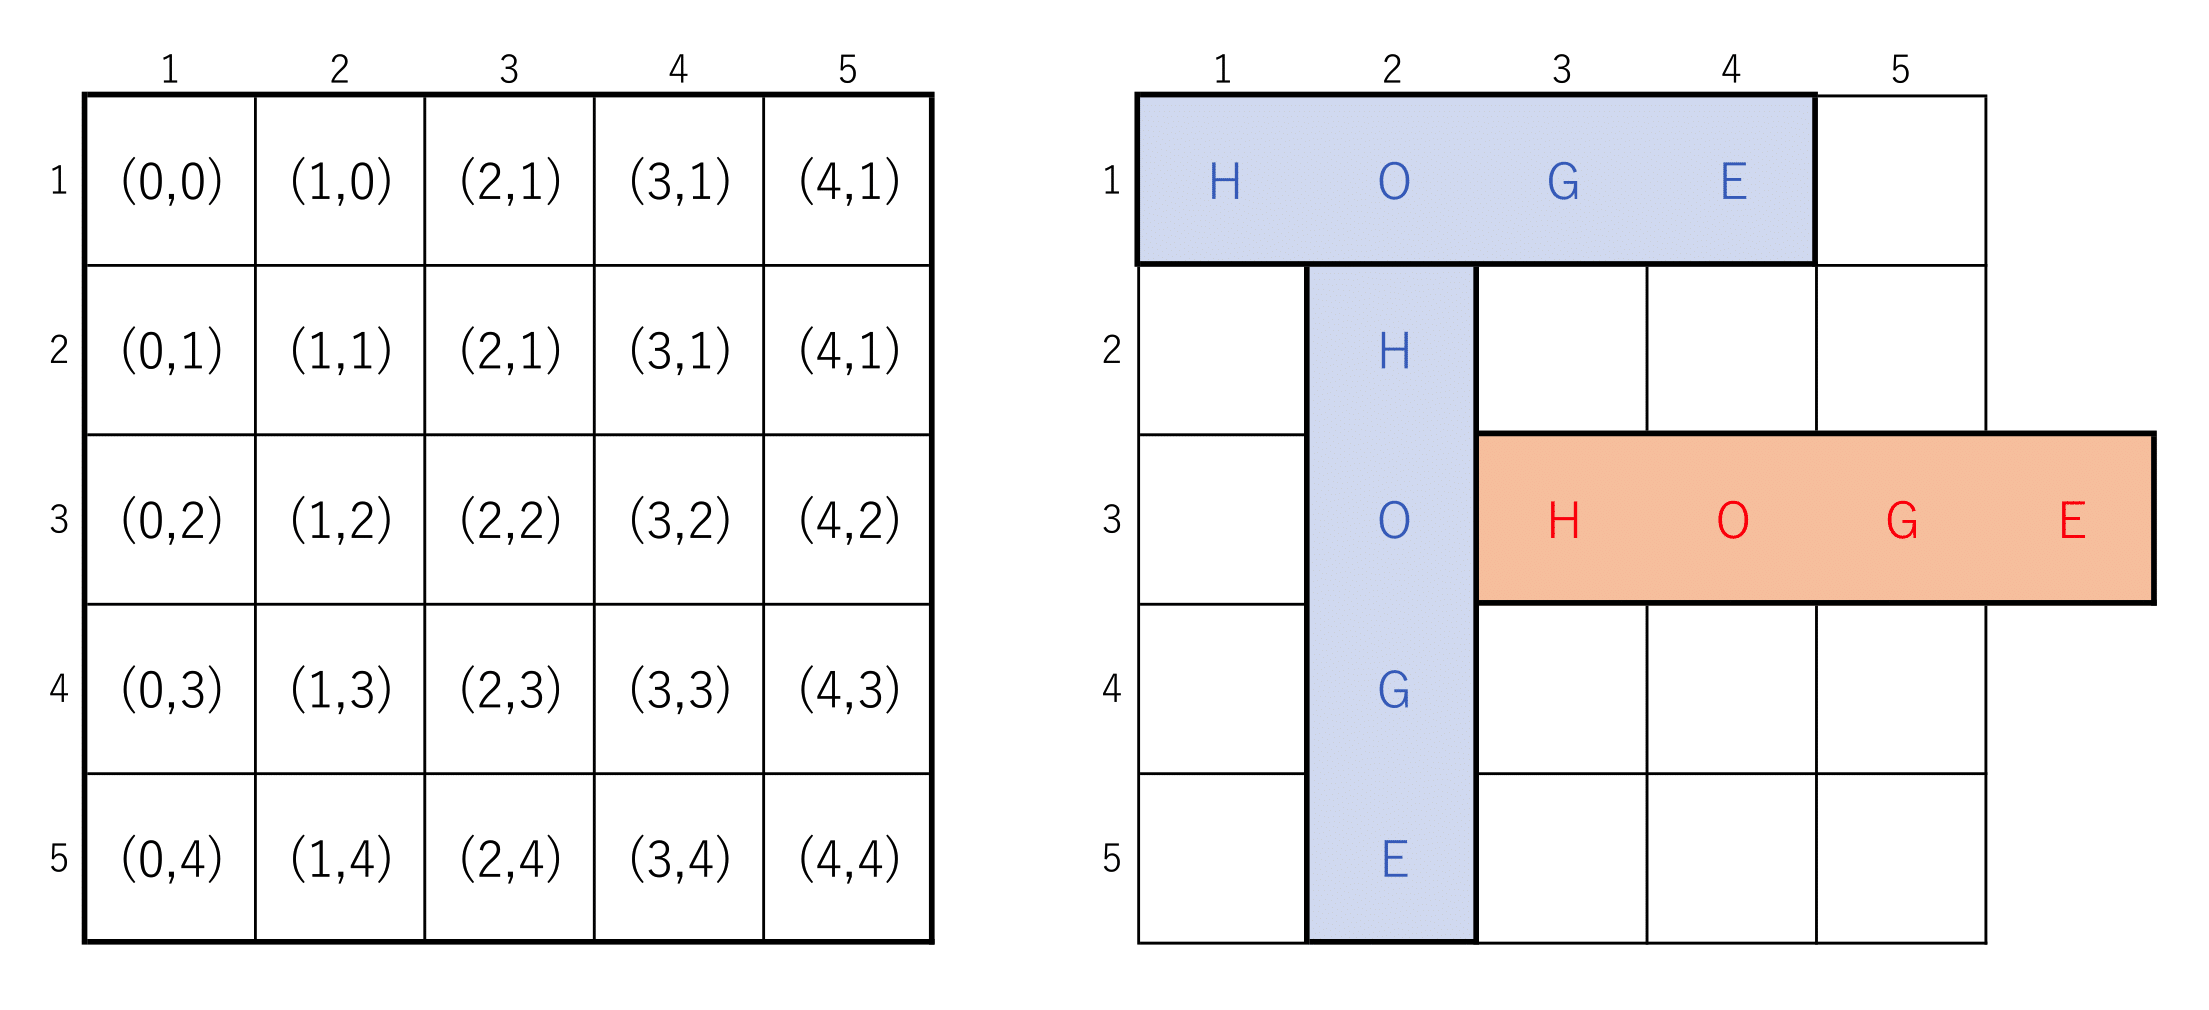

In [401]:
display(Image.open("fig/puzzles.png"))

これらの情報は次のフォーマットで整理される：
  * div : 単語を置く向き(0: 横, 1: 縦)
  * x : 単語の先頭文字のx座標
  * y : 単語の先頭文字のy座標

In [402]:
pd.DataFrame([[0,0,0],[0,0,1],[0,1,0],[0,1,1],
              [1,0,0],[1,0,1],[1,1,0],[1,1,1]],
             columns=["div","x","y"],
             index=["p1","p2","p3","p4","p5","p6","p7","p8"]
            )

,div,x,y
p1,0,0,0
p2,0,0,1
p3,0,1,0
p4,0,1,1
p5,1,0,0
p6,1,0,1
p7,1,1,0
p8,1,1,1


メンバ変数は以下の通り：
  * size : Placeableオブジェクトの大きさ
  * width : 引数のパズルの横幅
  * height : 引数のパズルの縦幅
  * dic : 引数の辞書
  * div : Placeable成分の文字列の方向
  * k : Placeable成分の文字の番号
  * i : Placeable成分のx方向の座標
  * j : Placeable成分のy方向の座標
  * used : Placeable成分が既に使われているかどうか(bool)
  * invP : Placeableオブジェクトの逆写像


In [490]:
class Placeable():
    def __init__(self, puzzle, dictionary):
        self.size = 0
        self.width = puzzle.width
        self.height = puzzle.height
        self.dic = dictionary
        self.div = np.zeros(2*self.dic.size*self.width*self.height, dtype='int64')
        self.k = np.zeros(2*self.dic.size*self.width*self.height, dtype='int64')
        self.i = np.zeros(2*self.dic.size*self.width*self.height, dtype='int64')
        self.j = np.zeros(2*self.dic.size*self.width*self.height, dtype='int64')
        self.used = np.zeros(2*self.dic.size*self.width*self.height, dtype = "bool")
        self.invP = np.zeros(2*self.dic.size*self.width*self.height, dtype='int64').reshape(2,self.dic.size,self.width,self.height)

        for div in range(2):
            for k in range(self.dic.size):
                if div == 0:
                    iMax = self.width - len(self.dic.data[k])
                    jMax = self.height - 1
                elif div == 1:
                    iMax = self.width - 1
                    jMax = self.height - len(self.dic.data[k])
                
                for i in range(iMax):
                    for j in range(jMax):
                        self.div[self.size] = div
                        self.k[self.size] = k
                        self.i[self.size] = i
                        self.j[self.size] = j
                        self.invP[div][k][i][j] = self.size
                        self.size += 1
        print("Placeable object has made.")
        print(" - placeable size : %d/%d(max shape)" % (self.size, self.div.size))

In [491]:
placeable = Placeable(puzzle, dic)

Placeable object has made.
 - placeable size : 3780/26496(max shape)


***
## パズル生成
ここから、実際にパズルを生成していく。
まずは、`placeable`オブジェクトからランダムに単語の配置可能位置を取得し、パズルの盤面に単語を詰められなくなるまで詰めます。
その準備として、`placeable`オブジェクトのインデックスの順番をランダムに取得できるよう、`randomIndex`を作成します：

In [492]:
# Make a random index of placeable
randomIndex = np.arange(placeable.size)
print(randomIndex)
seed(seed = randomSeed)
shuffle(randomIndex)
print(randomIndex)

[   0    1    2 ... 3777 3778 3779]
[ 268 2516  954 ...   74 2224  338]


次に、パズルに単語を詰めていきます。
単語を詰めるための関数として、`add`メソッドを`Puzzle`クラスに追加します：

In [501]:
### isEnabledAdd
def isEnableAdd(self, plc, idx):
    # Get the word length
    wLen = len(plc.dic.data[plc.k[idx]])
    crossing = False
    
    # If 0 words used, return True
    if self.solSize == 0:
        return True
    
    # If the word is already in use, return False
    if plc.used[idx] == True:
        return False
    
    # If the word does not fit in the puzzle, return False
    if plc.div[idx] == 0 and plc.i[idx]+len > self.width:
        return False
    if plc.div[idx] == 1 and plc.j[idx]+len > self.height:
        return False
    
    # Determine intersection
    for p in range(wLen):
        if plc.div[idx] == 0 and self.cell[plc.i[idx]+p][plc.j[idx]] != 0:
            crossing = True
            #if(puzzle[T[t].i + p][T[t].j] != Dict.x[T[t].k][p])っている?
        elif plc.div[idx] == 1 and self.cell[plc.i[idx]][plc.j[idx]+p] != 0:
            crossing = True
            #ifいる?
    ## ここまで編集済み。common.c 451行目
    ## 次はfor (p = 0; p < length; p++)部分から
    
        
setattr(Puzzle, "isEnableAdd", isEnableAdd)

### add
def add(self, placeable, idx):
    # パズルに単語が詰め込み可能かどうかを判定
    if self.isEnableAdd(placeable, idx) == False:
        return
    
    # 詰め込み可能であれば、盤面に配置

setattr(Puzzle, "add", add)

`add`メソッドが定義できたので、`puzzle`オブジェクトで呼び出します。ただし、引数は`placeable`配列からランダムに与えます：

In [503]:
for p in range(placeable.size):
    puzzle.add(placeable, randomIndex[p])